# Mounting Google Drive for dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cp /content/drive/MyDrive/Sentiment-Analysis/Reviews.csv /content/

#Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [4]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments

In [6]:
import torch
from torch import nn
from torch.utils.data import Dataset

# Data loading and pre-processing

In [7]:
df = pd.read_csv('Reviews.csv')

In [8]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [9]:
df = df[['Score', 'Summary', 'Text']]

In [10]:
df.dropna(inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 568427 entries, 0 to 568453
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Score    568427 non-null  int64 
 1   Summary  568427 non-null  object
 2   Text     568427 non-null  object
dtypes: int64(1), object(2)
memory usage: 17.3+ MB


In [12]:
df['sentiment'] = df['Score'].apply(lambda x: 0 if x <= 2 else (1 if x == 3 else 2))

In [13]:
df['review'] = df['Summary'] + " " + df['Text']

In [14]:
df = df[['review', 'sentiment']]

In [15]:
df['review'] = df['review'].apply(lambda x: re.sub(r'<.*?>', '', str(x)))

In [16]:
df.head()

,review,sentiment
0,Good Quality Dog Food I have bought several of...,2
1,Not as Advertised Product arrived labeled as J...,0
2,"""Delight"" says it all This is a confection tha...",2
3,Cough Medicine If you are looking for the secr...,0
4,Great taffy Great taffy at a great price. The...,2


In [17]:
df['sentiment'].value_counts()

,count
sentiment,
2,443777
0,82012
1,42638


In [18]:
df_small = df.groupby('sentiment', group_keys=False).apply(lambda x: x.sample(min(len(x), 33000), random_state=42))

/tmp/ipython-input-1509509848.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_small = df.groupby('sentiment', group_keys=False).apply(lambda x: x.sample(min(len(x), 33000), random_state=42))


In [19]:
class_weights = compute_class_weight('balanced', classes=np.array([0,1,2]), y=df_small['sentiment'])

In [20]:
class_weights

array([1., 1., 1.])

In [21]:
train_df, val_df = train_test_split(df_small, test_size=0.2, stratify=df_small['sentiment'], random_state=42)

# Tokenization

In [22]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
def tokenize_data(df):
    return tokenizer(df['review'].tolist(), padding=True, truncation=True, max_length=512)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [23]:
train_encodings = tokenizer(train_df['review'].tolist(), padding=True, truncation=True, max_length=512, return_tensors='pt')
val_encodings = tokenizer(val_df['review'].tolist(), padding=True, truncation=True, max_length=512, return_tensors='pt')

# PyTorch Dataset

In [24]:
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = SentimentDataset(train_encodings, train_df['sentiment'].tolist())
val_dataset = SentimentDataset(val_encodings, val_df['sentiment'].tolist())


#Model Fine-Tuning & Training

In [25]:
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=3
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

In [28]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=3e-5,
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_steps=500,
    weight_decay=0.01,
    warmup_steps=200,
    fp16=True,
    gradient_accumulation_steps=2,
    load_best_model_at_end=True
)


In [29]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [32]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=class_weights_tensor.to(model.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss


trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [33]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.459000,0.416382,0.829242,0.831513,0.837237,0.829242
2,0.339200,0.392679,0.849242,0.849626,0.850103,0.849242


TrainOutput(global_step=2476, training_loss=0.42656511790532864, metrics={'train_runtime': 1846.5766, 'train_samples_per_second': 85.78, 'train_steps_per_second': 1.341, 'total_flos': 2.09832101462016e+16, 'train_loss': 0.42656511790532864, 'epoch': 2.0})

# Performance Metrics

In [34]:
predictions = trainer.predict(val_dataset)
preds = predictions.predictions.argmax(-1)

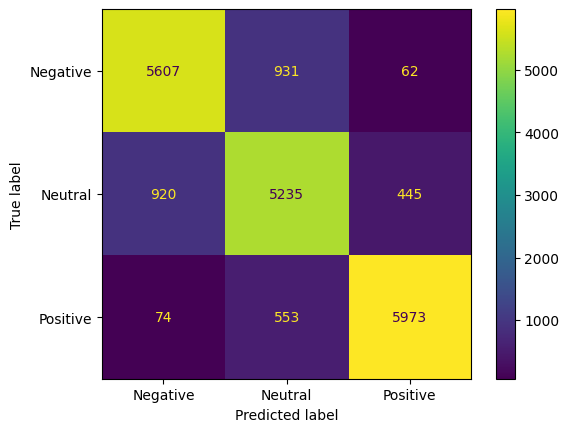

In [35]:
# Confusion matrix
cm = confusion_matrix(val_df['sentiment'], preds)
disp = ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot()

In [36]:
# Classification report
print(classification_report(val_df['sentiment'], preds))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      6600
           1       0.78      0.79      0.79      6600
           2       0.92      0.91      0.91      6600

    accuracy                           0.85     19800
   macro avg       0.85      0.85      0.85     19800
weighted avg       0.85      0.85      0.85     19800



# Test

In [43]:
def predict_sentiment(text):
    # Tokenize
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512, padding=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Predict
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pred = torch.argmax(probs, dim=-1).item()

    sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    confidence = probs[0][pred].item() * 100

    return sentiment_map[pred], confidence

# Test examples
test_reviews = [
    "Working good I used the pibox external case it's not working, I though ssd is dead then I used another external box form amazon then ssd is working perfect",
    "I upgraded from an HDD to this Crucial SSD and honestly, it felt like the perfect purchase for my laptop. The boot-up speed was insanely fast, and everyday performance saw a major boost. In terms of compatibility, it fit right in without any issues, and the connectivity was seamless just plug. The ease of use during installation made the whole process hassle-free, even for someone without much tech experience. The build quality feels premium, and the laptop now runs cooler and quieter, which adds to the overall comfort of use. If you're looking for a solid speed upgrade, this drive won’t disappoint.",
    "Using the Crucial BX500 1TB for 8 months – speed is still solid, no issues at price of Rs 4600. Build quality is great. Only wish the warranty was longer than 3 years. Still, worth it for everyday use!.",
    "I bought it 2 years ago and it was working well and good, but now it started showing its true colors. The writing speed reduced to 5-10 MB/s. First I thought there is an issue with my laptop, but I was wrong. There is no DRAM and there is a feature called Active Garbage Collection that does background clean-up for the SSD so that it can remove the junk data which can cause performance reduction and system freezes, but guess what? It needs some idle time to do that process. You need to leave your PC/laptop in BIOS for idle for 6-8 hours!! And even after that there is no guarantee that it will make the drive back to normal!! If you are planning to buy this SSD, then you should reconsider your decision. There are plenty of other SSDs available, so go for them.",
]

for review in test_reviews:
    sentiment, confidence = predict_sentiment(review)
    print(f"Review: {review}")
    print(f"Sentiment: {sentiment} ({confidence:.2f}% confident)\n")


Review: Working good I used the pibox external case it's not working, I though ssd is dead then I used another external box form amazon then ssd is working perfect
Sentiment: Positive (49.74% confident)

Review: I upgraded from an HDD to this Crucial SSD and honestly, it felt like the perfect purchase for my laptop. The boot-up speed was insanely fast, and everyday performance saw a major boost. In terms of compatibility, it fit right in without any issues, and the connectivity was seamless just plug. The ease of use during installation made the whole process hassle-free, even for someone without much tech experience. The build quality feels premium, and the laptop now runs cooler and quieter, which adds to the overall comfort of use. If you're looking for a solid speed upgrade, this drive won’t disappoint.
Sentiment: Positive (98.03% confident)

Review: Using the Crucial BX500 1TB for 8 months – speed is still solid, no issues at price of Rs 4600. Build quality is great. Only wish the

In [39]:
# Random validation samples
sample_reviews = val_df.sample(5)
for idx, row in sample_reviews.iterrows():
    pred_sentiment, conf = predict_sentiment(row['review'])
    actual = ['Negative', 'Neutral', 'Positive'][row['sentiment']]
    print(f"Review: {row['review'][:100]}...")
    print(f"Predicted: {pred_sentiment} | Actual: {actual}\n")


Review: Great product Icing eyes arrived in a timely manner, payment was easy and product was as described. ...
Predicted: Positive | Actual: Positive

Review: Love this...replaced soda for me I love the Sweetleaf line of flavorings.  I use this in my coffee a...
Predicted: Positive | Actual: Positive

Review: Fast delivery and good quality!!! The item was shipped and delivered very quickly. I got all items r...
Predicted: Positive | Actual: Positive

Review: Quanty???? This food is working well for my 19 1/2 year-old-cat with kidney problems.  But I can't f...
Predicted: Neutral | Actual: Neutral

Review: Good but not as good as I remember I could be wrong but it seems like these used to be better. After...
Predicted: Positive | Actual: Positive



#Saving the Model

In [44]:
model.save_pretrained('./sentiment_model')
tokenizer.save_pretrained('./sentiment_model')

('./sentiment_model/tokenizer_config.json',
 './sentiment_model/special_tokens_map.json',
 './sentiment_model/vocab.txt',
 './sentiment_model/added_tokens.json')

In [47]:
!cp -r /content/sentiment_model/ /content/drive/MyDrive/Sentiment-Analysis/

In [48]:
!cp -r /content/wandb /content/drive/MyDrive/Sentiment-Analysis/